In [47]:
pip install yfinance PyPortfolioOpt matplotlib pandas numpy scipy scikit-learn

In [48]:
# Imports and Setup
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Portfolio Optimization
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.objective_functions import L2_reg

from scipy.stats import skew, kurtosis
from numpy.linalg import eigh
import warnings

warnings.filterwarnings("ignore")

In [49]:
# Load Data
tickers = ['SPY', 'IWM', 'EFA', 'EEM', 'AGG', 'LQD', 'HYG', 'TLT', 'GLD', 'VNQ', 'DBC', 'VT', 'XLE', 'XLK', 'UUP']
start_date = "2008-07-01"
end_date = "2025-03-01"

prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)["Close"].dropna()
daily_returns = prices.pct_change().dropna()


[*********************100%***********************]  15 of 15 completed


In [50]:
# Download daily 3-month T-Bill rate (annualized) as proxy for risk-free rate
rf_data = yf.download("^IRX", start=start_date, end=end_date)["Close"] / 100
rf_data = rf_data.resample('B').ffill()
rf_daily = rf_data / 252
rf_daily.name = "RiskFreeRate"

[*********************100%***********************]  1 of 1 completed


In [51]:
# Random Matrix Theory (RMT) Covariance Filter
def rmt_denoised_covariance(returns, relax=1.0, label=""):
    T, N = returns.shape
    sample_cov = np.cov(returns, rowvar=False)
    eigenvals, eigenvecs = eigh(sample_cov)
    q = T / N
    lambda_plus = (sample_cov.trace() / N) * (1 + 1 / np.sqrt(q))**2 * relax
    filtered = np.clip(eigenvals, None, lambda_plus)
    print(f"[{label}] λ₊ = {lambda_plus:.4f} — Clipped {np.sum(eigenvals > lambda_plus)} eigenvalue(s)")
    return pd.DataFrame(eigenvecs @ np.diag(filtered) @ eigenvecs.T, index=returns.columns, columns=returns.columns)

In [52]:
# Optional Shrinkage after RMT denoising
def shrink_covariance(rmt_cov, alpha=0.98):
    n_assets = rmt_cov.shape[0]
    identity = np.eye(n_assets)
    return alpha * rmt_cov + (1 - alpha) * identity

In [53]:
# Performance Metrics Function
def compute_metrics(port_returns, label):
    metrics = {
        "Mean Return": port_returns.mean(),
        "Annual Return": port_returns.mean() * 252,
        "Geometric Return": (np.prod(1 + port_returns))**(252 / len(port_returns)) - 1,
        "Min Return": port_returns.min(),
        "Max Drawdown (%)": ((1 + port_returns).cumprod() / (1 + port_returns).cumprod().cummax() - 1).min() * 100,
        "Max 10-Day Drawdown (%)": port_returns.rolling(10).sum().min() * 100,
        "Sharpe Ratio": ((port_returns.mean() * 252) - (rf_daily.loc[port_returns.index].mean() * 252)) / (port_returns.std() * np.sqrt(252)),
        "Volatility": port_returns.std() * np.sqrt(252),
        "Skewness": skew(port_returns),
        "Kurtosis": kurtosis(port_returns),
        "VaR (%)": np.percentile(port_returns, 5) * 100,
        "CVaR (%)": port_returns[port_returns <= np.percentile(port_returns, 5)].mean() * 100,
    }
    return pd.Series(metrics, name=label), (1 + port_returns).cumprod()


In [54]:
import cvxpy as cp

# Gamma Sweep in RMT Out-of-Sample Regimes
gamma_grid = [0.1, 0.15, 0.2, 0.3, 0.5, 1.0]
lambda_grid = [0.1, 0.5, 1.0]  # Optionally, you can grid-search lambda too later
regimes = [("2008-07-01", "2018-12-31", "2019-01-01", "2025-03-01")]

rmt_gamma_metrics = {}

for train_start, train_end, test_start, test_end in regimes:
    train_prices = prices.loc[train_start:train_end]
    test_prices = prices.loc[test_start:test_end]
    train_returns = train_prices.pct_change().dropna()
    test_returns = test_prices.pct_change().dropna()
    mu_train = mean_historical_return(train_prices, frequency=252)
    rf_train_mean = float(rf_daily.loc[train_returns.index].mean())

    for relax, relax_label in zip([1.2, 1.0, 1.4], ["RMT Relaxed (1.2)", "RMT Base (1.0)", "RMT High (1.4)"]):
        cov = rmt_denoised_covariance(train_returns, relax=relax, label=relax_label)
        cov = shrink_covariance(cov, alpha=0.98)
        rmt_gamma_metrics[relax_label] = {}

        for gamma in gamma_grid:
            try:
                # === Solve the new optimization problem manually ===
                w = cp.Variable(mu_train.shape[0])
                objective = cp.Maximize(w @ mu_train.values - 0.5 * 1.0 * cp.quad_form(w, cov.values) - gamma * cp.norm(w, 2)**2)
                constraints = [cp.sum(w) == 1, w >= 0]
                prob = cp.Problem(objective, constraints)
                prob.solve()

                weights = pd.Series(w.value, index=mu_train.index)

                returns = test_returns @ weights
                m, c = compute_metrics(returns, f"{relax_label} - Gamma {gamma}")
                rmt_gamma_metrics[relax_label][gamma] = (m, c)

            except Exception as e:
                print(f"Error optimizing {relax_label} at gamma={gamma}: {e}")

[RMT Relaxed (1.2)] λ₊ = 0.0002 — Clipped 1 eigenvalue(s)
[RMT Base (1.0)] λ₊ = 0.0002 — Clipped 2 eigenvalue(s)
[RMT High (1.4)] λ₊ = 0.0003 — Clipped 1 eigenvalue(s)


In [55]:
# Display Gamma Sensitivity Tables for Each RMT Variant
for relax_label, gamma_data in rmt_gamma_metrics.items():
    gamma_table = pd.concat([m for m, _ in gamma_data.values()], axis=1)
    gamma_table.columns = [f"Gamma {g}" for g in gamma_data.keys()]
    print(f"\n--- Gamma Sensitivity Analysis for {relax_label} ---")
    display(gamma_table.round(6))



--- Gamma Sensitivity Analysis for RMT Relaxed (1.2) ---


,Gamma 0.1,Gamma 0.15,Gamma 0.2,Gamma 0.3,Gamma 0.5,Gamma 1.0
Mean Return,0.000639,0.000571,0.000531,0.000487,0.000447,0.000424
Annual Return,0.161059,0.143869,0.133691,0.122714,0.112565,0.106944
Geometric Return,0.152879,0.136722,0.127453,0.117748,0.108344,0.103074
Min Return,-0.113185,-0.10301,-0.09535,-0.086782,-0.081336,-0.078879
Max Drawdown (%),-30.873433,-29.098483,-27.607692,-25.639863,-24.31378,-24.408197
Max 10-Day Drawdown (%),-24.793013,-24.1893,-23.496517,-22.374027,-21.668213,-22.214175
Sharpe Ratio,Ticker ^IRX 0.707078 dtype: float64,Ticker ^IRX 0.675805 dtype: float64,Ticker ^IRX 0.661434 dtype: float64,Ticker ^IRX 0.653011 dtype: float64,Ticker ^IRX 0.634895 dtype: float64,Ticker ^IRX 0.622636 dtype: float64
Volatility,0.193241,0.176747,0.1652,0.15052,0.138829,0.132536
Skewness,-0.588579,-0.626263,-0.646419,-0.692841,-0.786398,-0.918471
Kurtosis,11.634631,12.064938,12.296068,12.934528,14.139577,15.865165



--- Gamma Sensitivity Analysis for RMT Base (1.0) ---


,Gamma 0.1,Gamma 0.15,Gamma 0.2,Gamma 0.3,Gamma 0.5,Gamma 1.0
Mean Return,0.000639,0.000571,0.000531,0.000487,0.000447,0.000424
Annual Return,0.161062,0.143872,0.133693,0.122715,0.112566,0.106945
Geometric Return,0.152882,0.136725,0.127454,0.117749,0.108345,0.103075
Min Return,-0.11319,-0.103013,-0.095353,-0.086785,-0.081337,-0.07888
Max Drawdown (%),-30.874484,-29.099299,-27.608368,-25.64039,-24.314125,-24.408369
Max 10-Day Drawdown (%),-24.79365,-24.189799,-23.496933,-22.374386,-21.668458,-22.214299
Sharpe Ratio,Ticker ^IRX 0.707076 dtype: float64,Ticker ^IRX 0.675805 dtype: float64,Ticker ^IRX 0.661431 dtype: float64,Ticker ^IRX 0.653007 dtype: float64,Ticker ^IRX 0.634893 dtype: float64,Ticker ^IRX 0.622635 dtype: float64
Volatility,0.193246,0.176751,0.165203,0.150522,0.138831,0.132536
Skewness,-0.588601,-0.626279,-0.646431,-0.69285,-0.786405,-0.918474
Kurtosis,11.634978,12.065186,12.296242,12.934649,14.139668,15.865199



--- Gamma Sensitivity Analysis for RMT High (1.4) ---


,Gamma 0.1,Gamma 0.15,Gamma 0.2,Gamma 0.3,Gamma 0.5,Gamma 1.0
Mean Return,0.000639,0.000571,0.000531,0.000487,0.000447,0.000424
Annual Return,0.161056,0.143866,0.13369,0.122713,0.112564,0.106944
Geometric Return,0.152877,0.13672,0.127452,0.117748,0.108344,0.103074
Min Return,-0.113181,-0.103006,-0.095348,-0.08678,-0.081335,-0.078879
Max Drawdown (%),-30.872498,-29.097757,-27.607115,-25.639379,-24.313437,-24.408026
Max 10-Day Drawdown (%),-24.792473,-24.188875,-23.496175,-22.373699,-21.667965,-22.214051
Sharpe Ratio,Ticker ^IRX 0.707078 dtype: float64,Ticker ^IRX 0.675805 dtype: float64,Ticker ^IRX 0.661435 dtype: float64,Ticker ^IRX 0.653014 dtype: float64,Ticker ^IRX 0.634896 dtype: float64,Ticker ^IRX 0.622637 dtype: float64
Volatility,0.193236,0.176743,0.165197,0.150517,0.138828,0.132535
Skewness,-0.588562,-0.626251,-0.64641,-0.692833,-0.786392,-0.918469
Kurtosis,11.63436,12.064741,12.295926,12.934422,14.139484,15.865131


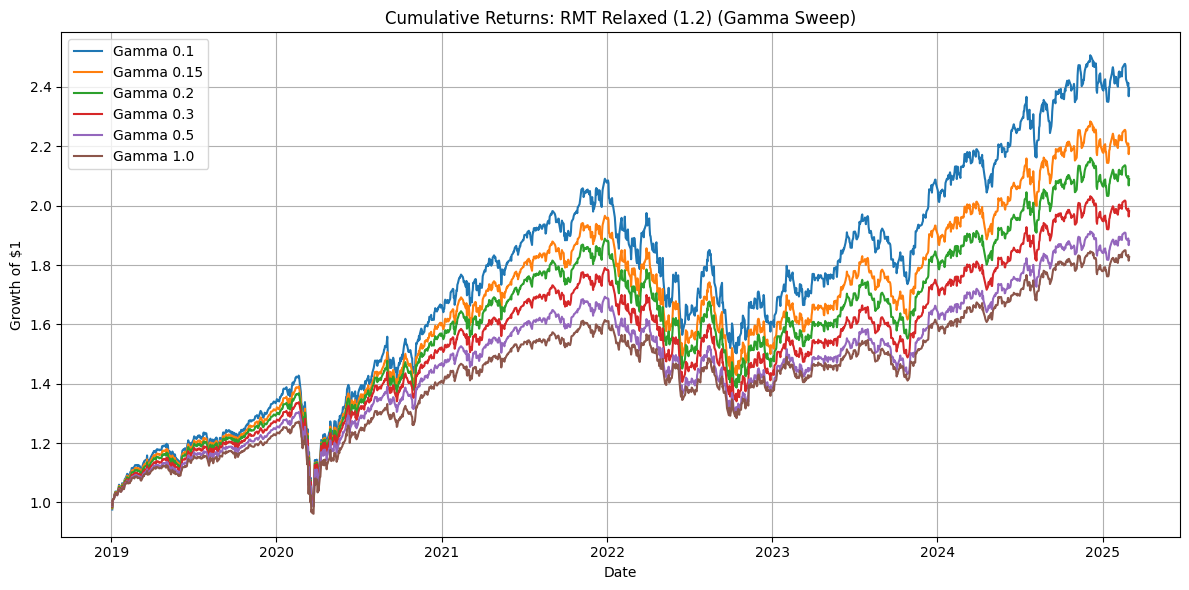

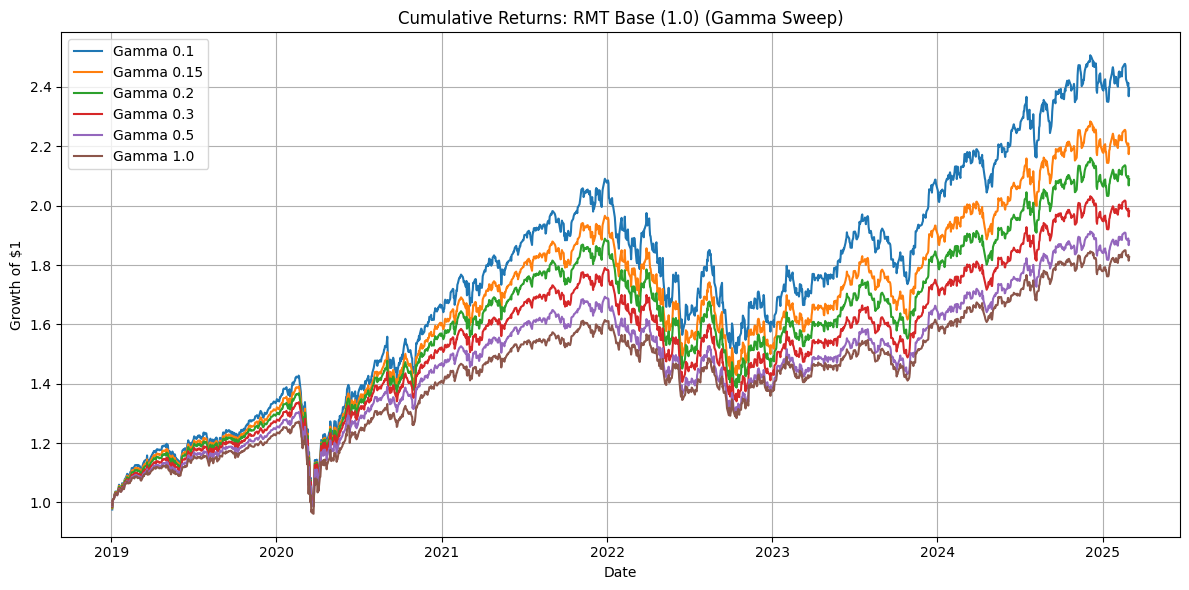

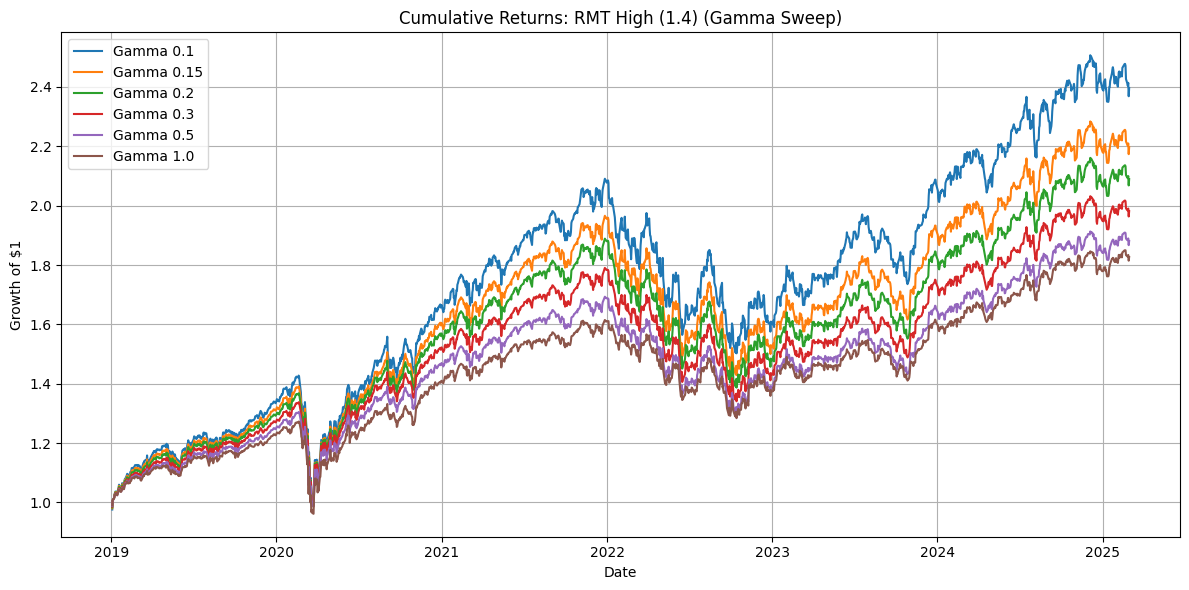

In [56]:
# Plot Cumulative Returns per Gamma for Each RMT Variant
for relax_label, gamma_data in rmt_gamma_metrics.items():
    plt.figure(figsize=(12, 6))
    for gamma, (_, curve) in gamma_data.items():
        plt.plot(curve, label=f"Gamma {gamma}")
    plt.title(f"Cumulative Returns: {relax_label} (Gamma Sweep)")
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{relax_label.replace(' ', '_').replace('.', '')}_gamma_returns.png", dpi=300)
    plt.show()


In [57]:
# Static Models on Full Period
metrics, curves = {}, {}
mu_full = mean_historical_return(prices, frequency=252)
subset = daily_returns.columns[:10]
rf_full_mean = float(rf_daily.loc[prices.index].mean())

# MVO-LW (Full Universe)
cov_lw = CovarianceShrinkage(prices).ledoit_wolf()
ef = EfficientFrontier(mu_full, cov_lw)
ef.add_objective(L2_reg, gamma=0.1)
ef.max_sharpe(risk_free_rate=rf_full_mean)
weights_lw = pd.Series(ef.clean_weights())
m, c = compute_metrics(daily_returns @ weights_lw, "MVO-LW (Static)")
metrics["MVO-LW (Static)"] = m
curves["MVO-LW (Static)"] = c

# Equal-Weighted
equal_weights = pd.Series(1 / len(tickers), index=tickers)
m, c = compute_metrics(daily_returns @ equal_weights, "Equal-Weighted")
metrics["Equal-Weighted"] = m
curves["Equal-Weighted"] = c

# MVO-Naive
sample_cov_df = pd.DataFrame(np.cov(daily_returns, rowvar=False), index=daily_returns.columns, columns=daily_returns.columns)
ef = EfficientFrontier(mu_full, sample_cov_df)
ef.max_sharpe(risk_free_rate=rf_full_mean)
weights_naive = pd.Series(ef.clean_weights())
m, c = compute_metrics(daily_returns @ weights_naive, "MVO-Naive")
metrics["MVO-Naive"] = m
curves["MVO-Naive"] = c

# LW Subset (First 10 ETFs only)
mu_sub = mean_historical_return(prices[subset], frequency=252)
cov_sub = CovarianceShrinkage(prices[subset]).ledoit_wolf()
rf_subset_mean = float(rf_daily.loc[prices[subset].index].mean())
ef = EfficientFrontier(mu_sub, cov_sub)
ef.add_objective(L2_reg, gamma=0.1)
ef.max_sharpe(risk_free_rate=rf_subset_mean)
weights_sub = pd.Series(ef.clean_weights())
m, c = compute_metrics(daily_returns[subset] @ weights_sub, "LW Subset")
metrics["LW Subset"] = m
curves["LW Subset"] = c

In [58]:
for relax_label, gamma_data in rmt_gamma_metrics.items():
    # Select gamma with the highest Sharpe Ratio
    best_gamma = max(gamma_data.items(), key=lambda x: x[1][0]["Sharpe Ratio"].item())[0]
    m, c = gamma_data[best_gamma]
    metrics[f"{relax_label} (Best γ={best_gamma})"] = m
    curves[f"{relax_label} (Best γ={best_gamma})"] = c

In [59]:
# ETF Benchmark Metrics
etf_metrics, etf_curves = {}, {}
for ticker in daily_returns.columns:
    port_returns = daily_returns[ticker]
    m, c = compute_metrics(port_returns, ticker)
    etf_metrics[ticker] = m
    etf_curves[ticker] = c

In [60]:
# Combine all metrics
oos_table = pd.concat(metrics.values(), axis=1).round(6)
etf_table = pd.concat(etf_metrics.values(), axis=1).round(6)
metrics_table = pd.concat(list(metrics.values()) + list(etf_metrics.values()), axis=1).round(6)

print("\n--- Final Out-of-Sample Model Comparison Table ---")
display(oos_table)
print("\n--- Individual ETF Benchmark Performance ---")
display(etf_table)
print("\n--- Full Metrics Table: Models + ETFs ---")
display(metrics_table)


--- Final Out-of-Sample Model Comparison Table ---


,MVO-LW (Static),Equal-Weighted,MVO-Naive,LW Subset,RMT Relaxed (1.2) - Gamma 0.1,RMT Base (1.0) - Gamma 0.1,RMT High (1.4) - Gamma 0.1
Mean Return,0.000384,0.000293,0.000219,0.000326,0.000639,0.000639,0.000639
Annual Return,0.096741,0.073729,0.05531,0.08215,0.161059,0.161062,0.161056
Geometric Return,0.095439,0.067275,0.055844,0.080023,0.152879,0.152882,0.152877
Min Return,-0.060339,-0.075298,-0.034279,-0.059278,-0.113185,-0.11319,-0.113181
Max Drawdown (%),-23.159406,-32.633024,-7.096324,-23.511451,-30.873433,-30.874484,-30.872498
Max 10-Day Drawdown (%),-15.301956,-22.892124,-5.604241,-18.301317,-24.793013,-24.79365,-24.792473
Sharpe Ratio,Ticker ^IRX 0.807907 dtype: float64,Ticker ^IRX 0.474744 dtype: float64,Ticker ^IRX 0.998727 dtype: float64,Ticker ^IRX 0.696185 dtype: float64,Ticker ^IRX 0.707078 dtype: float64,Ticker ^IRX 0.707076 dtype: float64,Ticker ^IRX 0.707078 dtype: float64
Volatility,0.105547,0.131145,0.043898,0.101527,0.193241,0.193246,0.193236
Skewness,-0.017118,-0.236963,-0.308643,-0.131232,-0.588579,-0.588601,-0.588562
Kurtosis,12.58027,15.129309,20.425145,12.759797,11.634631,11.634978,11.63436



--- Individual ETF Benchmark Performance ---


,AGG,DBC,EEM,EFA,GLD,HYG,IWM,LQD,SPY,TLT,UUP,VNQ,VT,XLE,XLK
Mean Return,0.000117,-0.000065,0.000231,0.000257,0.000307,0.000233,0.000451,0.000185,0.000519,0.000164,0.000113,0.00046,0.000385,0.00032,0.00071
Annual Return,0.02958,-0.016305,0.058115,0.064776,0.077353,0.058823,0.113679,0.046692,0.130779,0.041354,0.028563,0.115973,0.097089,0.080516,0.178945
Geometric Return,0.028451,-0.034136,0.019438,0.041099,0.064786,0.05378,0.085625,0.043438,0.117267,0.029541,0.025658,0.072344,0.078289,0.033324,0.164096
Min Return,-0.068395,-0.079444,-0.161662,-0.111632,-0.087808,-0.080974,-0.132669,-0.091111,-0.109424,-0.066683,-0.032196,-0.195138,-0.12138,-0.201412,-0.13814
Max Drawdown (%),-18.43295,-76.362636,-58.678424,-52.789203,-45.555013,-30.359686,-53.884049,-24.954871,-47.165223,-48.351138,-22.19095,-66.12508,-49.757496,-71.262767,-44.225669
Max 10-Day Drawdown (%),-10.339723,-24.596082,-41.00078,-32.881839,-23.386499,-21.699161,-38.910074,-23.17212,-30.114945,-11.063188,-9.64988,-38.630259,-31.489289,-60.487778,-25.918925
Sharpe Ratio,Ticker ^IRX 0.328813 dtype: float64,Ticker ^IRX -0.144965 dtype: float64,Ticker ^IRX 0.166896 dtype: float64,Ticker ^IRX 0.241009 dtype: float64,Ticker ^IRX 0.386063 dtype: float64,Ticker ^IRX 0.41684 dtype: float64,Ticker ^IRX 0.40806 dtype: float64,Ticker ^IRX 0.385914 dtype: float64,Ticker ^IRX 0.598895 dtype: float64,Ticker ^IRX 0.19094 dtype: float64,Ticker ^IRX 0.212743 dtype: float64,Ticker ^IRX 0.344664 dtype: float64,Ticker ^IRX 0.411732 dtype: float64,Ticker ^IRX 0.224137 dtype: float64,Ticker ^IRX 0.721479 dtype: float64
Volatility,0.05508,0.19159,0.279496,0.221186,0.170658,0.113603,0.250479,0.091272,0.199219,0.156517,0.080355,0.303209,0.207953,0.308059,0.23213
Skewness,-2.010041,-0.443811,0.686141,-0.032934,-0.08503,0.764686,-0.37937,0.053346,-0.082267,0.096353,-0.018819,-0.021189,-0.344443,-0.273794,-0.015033
Kurtosis,52.3676,3.618409,21.604128,14.388471,7.459103,41.676609,6.467477,57.594716,14.683911,3.131787,3.642591,17.283125,12.812971,12.76112,9.376924



--- Full Metrics Table: Models + ETFs ---


,MVO-LW (Static),Equal-Weighted,MVO-Naive,LW Subset,RMT Relaxed (1.2) - Gamma 0.1,RMT Base (1.0) - Gamma 0.1,RMT High (1.4) - Gamma 0.1,AGG,DBC,EEM,...,HYG,IWM,LQD,SPY,TLT,UUP,VNQ,VT,XLE,XLK
Mean Return,0.000384,0.000293,0.000219,0.000326,0.000639,0.000639,0.000639,0.000117,-0.000065,0.000231,...,0.000233,0.000451,0.000185,0.000519,0.000164,0.000113,0.00046,0.000385,0.00032,0.00071
Annual Return,0.096741,0.073729,0.05531,0.08215,0.161059,0.161062,0.161056,0.02958,-0.016305,0.058115,...,0.058823,0.113679,0.046692,0.130779,0.041354,0.028563,0.115973,0.097089,0.080516,0.178945
Geometric Return,0.095439,0.067275,0.055844,0.080023,0.152879,0.152882,0.152877,0.028451,-0.034136,0.019438,...,0.05378,0.085625,0.043438,0.117267,0.029541,0.025658,0.072344,0.078289,0.033324,0.164096
Min Return,-0.060339,-0.075298,-0.034279,-0.059278,-0.113185,-0.11319,-0.113181,-0.068395,-0.079444,-0.161662,...,-0.080974,-0.132669,-0.091111,-0.109424,-0.066683,-0.032196,-0.195138,-0.12138,-0.201412,-0.13814
Max Drawdown (%),-23.159406,-32.633024,-7.096324,-23.511451,-30.873433,-30.874484,-30.872498,-18.43295,-76.362636,-58.678424,...,-30.359686,-53.884049,-24.954871,-47.165223,-48.351138,-22.19095,-66.12508,-49.757496,-71.262767,-44.225669
Max 10-Day Drawdown (%),-15.301956,-22.892124,-5.604241,-18.301317,-24.793013,-24.79365,-24.792473,-10.339723,-24.596082,-41.00078,...,-21.699161,-38.910074,-23.17212,-30.114945,-11.063188,-9.64988,-38.630259,-31.489289,-60.487778,-25.918925
Sharpe Ratio,Ticker ^IRX 0.807907 dtype: float64,Ticker ^IRX 0.474744 dtype: float64,Ticker ^IRX 0.998727 dtype: float64,Ticker ^IRX 0.696185 dtype: float64,Ticker ^IRX 0.707078 dtype: float64,Ticker ^IRX 0.707076 dtype: float64,Ticker ^IRX 0.707078 dtype: float64,Ticker ^IRX 0.328813 dtype: float64,Ticker ^IRX -0.144965 dtype: float64,Ticker ^IRX 0.166896 dtype: float64,...,Ticker ^IRX 0.41684 dtype: float64,Ticker ^IRX 0.40806 dtype: float64,Ticker ^IRX 0.385914 dtype: float64,Ticker ^IRX 0.598895 dtype: float64,Ticker ^IRX 0.19094 dtype: float64,Ticker ^IRX 0.212743 dtype: float64,Ticker ^IRX 0.344664 dtype: float64,Ticker ^IRX 0.411732 dtype: float64,Ticker ^IRX 0.224137 dtype: float64,Ticker ^IRX 0.721479 dtype: float64
Volatility,0.105547,0.131145,0.043898,0.101527,0.193241,0.193246,0.193236,0.05508,0.19159,0.279496,...,0.113603,0.250479,0.091272,0.199219,0.156517,0.080355,0.303209,0.207953,0.308059,0.23213
Skewness,-0.017118,-0.236963,-0.308643,-0.131232,-0.588579,-0.588601,-0.588562,-2.010041,-0.443811,0.686141,...,0.764686,-0.37937,0.053346,-0.082267,0.096353,-0.018819,-0.021189,-0.344443,-0.273794,-0.015033
Kurtosis,12.58027,15.129309,20.425145,12.759797,11.634631,11.634978,11.63436,52.3676,3.618409,21.604128,...,41.676609,6.467477,57.594716,14.683911,3.131787,3.642591,17.283125,12.812971,12.76112,9.376924


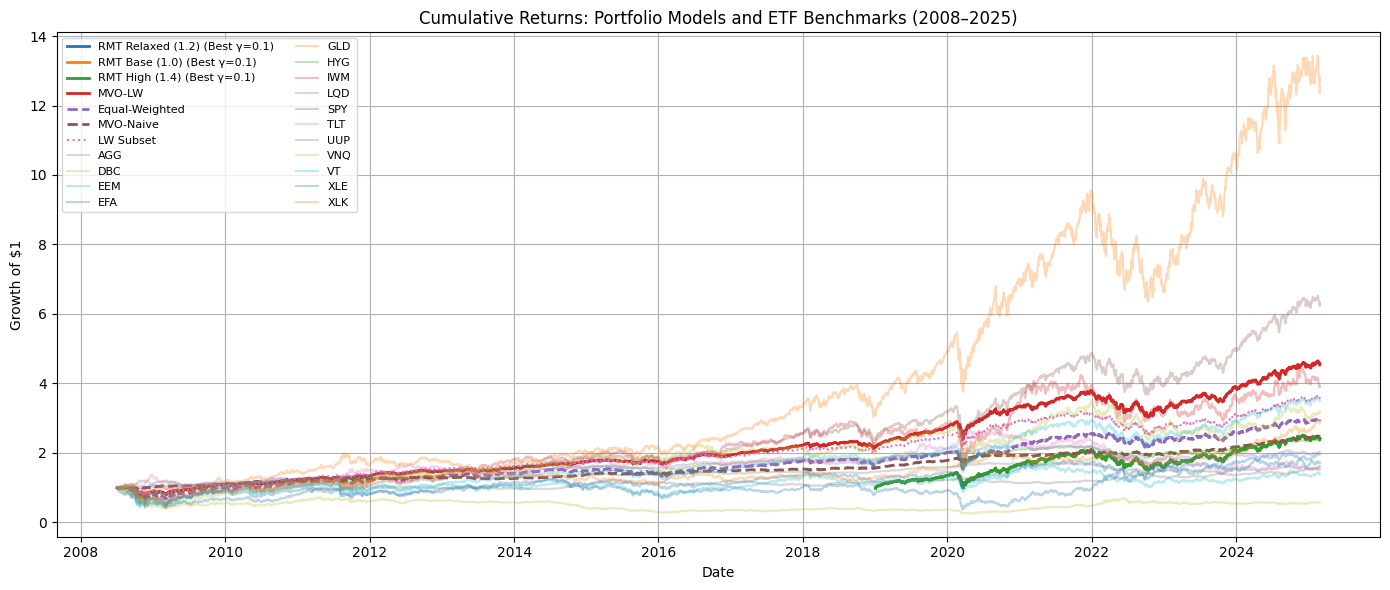

<Figure size 640x480 with 0 Axes>

In [61]:
plt.figure(figsize=(14, 6))

# Dynamically add RMT best-gamma curves
for label in curves:
    if "RMT" in label and "Best γ=" in label:
        plt.plot(curves[label], label=label, linewidth=2)

plt.plot(curves["MVO-LW (Static)"], label="MVO-LW", linewidth=2)
plt.plot(curves["Equal-Weighted"], label="Equal-Weighted", linewidth=2, linestyle="--")
plt.plot(curves["MVO-Naive"], label="MVO-Naive", linestyle="--", linewidth=2)
plt.plot(curves["LW Subset"], label="LW Subset", linestyle=":")

for ticker, curve in etf_curves.items():
    plt.plot(curve, label=ticker, alpha=0.3)

plt.title("Cumulative Returns: Portfolio Models and ETF Benchmarks (2008–2025)")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend(fontsize=8, loc="upper left", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("cumulative_returns_plot.png", dpi=300)
plt.show()

plt.savefig("cumulative_returns_plot.png", dpi=300)

In [62]:
print("\n--- Final Weights for Best-Gamma RMT Portfolios ---")

for relax, label in zip([1.2, 1.0, 1.4], ["RMT Relaxed (1.2)", "RMT Base (1.0)", "RMT High (1.4)"]):
    gamma_data = rmt_gamma_metrics[label]
    best_gamma = max(gamma_data.items(), key=lambda x: x[1][0]["Sharpe Ratio"].item())[0]

    # Rebuild training data
    train_start, train_end = "2008-07-01", "2018-12-31"
    train_prices = prices.loc[train_start:train_end]
    train_returns = train_prices.pct_change().dropna()
    mu_train = mean_historical_return(train_prices, frequency=252)
    rf_train_mean = float(rf_daily.loc[train_returns.index].mean())

    # Get covariance matrix and weights for best gamma
    cov = rmt_denoised_covariance(train_returns, relax=relax, label=label)
    ef = EfficientFrontier(mu_train, cov)
    ef.add_objective(L2_reg, gamma=best_gamma)
    ef.max_sharpe(risk_free_rate=rf_train_mean)
    weights = pd.Series(ef.clean_weights()).sort_values(ascending=False).round(4)

    print(f"\nFinal Weights ({label}, Best γ={best_gamma}):")
    print(weights)


--- Final Weights for Best-Gamma RMT Portfolios ---
[RMT Relaxed (1.2)] λ₊ = 0.0002 — Clipped 1 eigenvalue(s)

Final Weights (RMT Relaxed (1.2), Best γ=0.1):
XLK    0.1762
SPY    0.1304
IWM    0.1201
VNQ    0.1034
TLT    0.0879
HYG    0.0823
LQD    0.0771
VT     0.0747
AGG    0.0541
GLD    0.0385
EFA    0.0235
UUP    0.0204
EEM    0.0114
DBC    0.0000
XLE    0.0000
dtype: float64
[RMT Base (1.0)] λ₊ = 0.0002 — Clipped 2 eigenvalue(s)

Final Weights (RMT Base (1.0), Best γ=0.1):
XLK    0.1762
SPY    0.1304
IWM    0.1201
VNQ    0.1034
TLT    0.0878
HYG    0.0823
LQD    0.0771
VT     0.0747
AGG    0.0541
GLD    0.0385
EFA    0.0235
UUP    0.0203
EEM    0.0114
DBC    0.0000
XLE    0.0000
dtype: float64
[RMT High (1.4)] λ₊ = 0.0003 — Clipped 1 eigenvalue(s)

Final Weights (RMT High (1.4), Best γ=0.1):
XLK    0.1763
SPY    0.1304
IWM    0.1201
VNQ    0.1033
TLT    0.0879
HYG    0.0823
LQD    0.0772
VT     0.0747
AGG    0.0541
GLD    0.0386
EFA    0.0235
UUP    0.0204
EEM    0.0114
DBC    0.

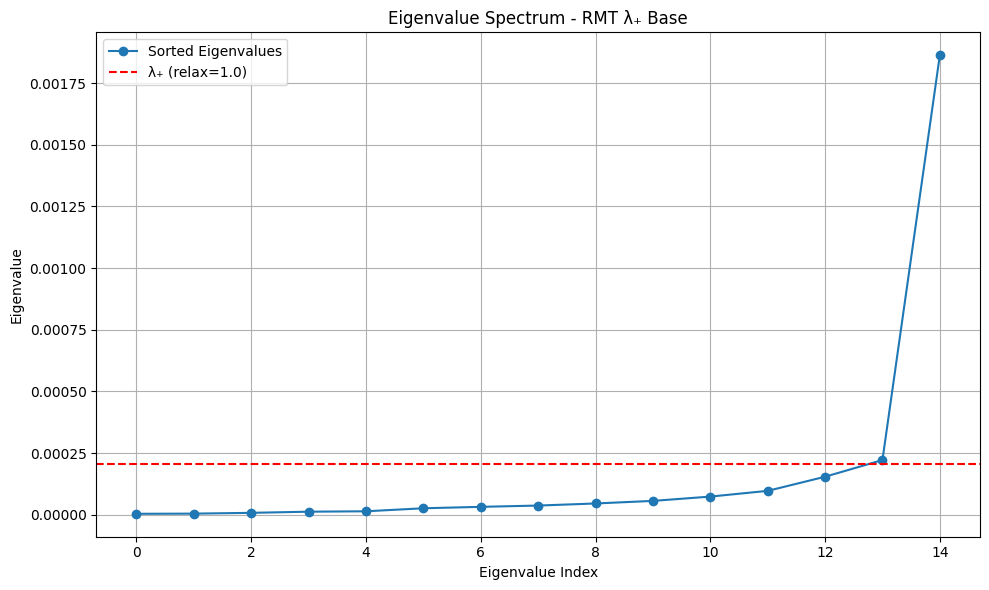

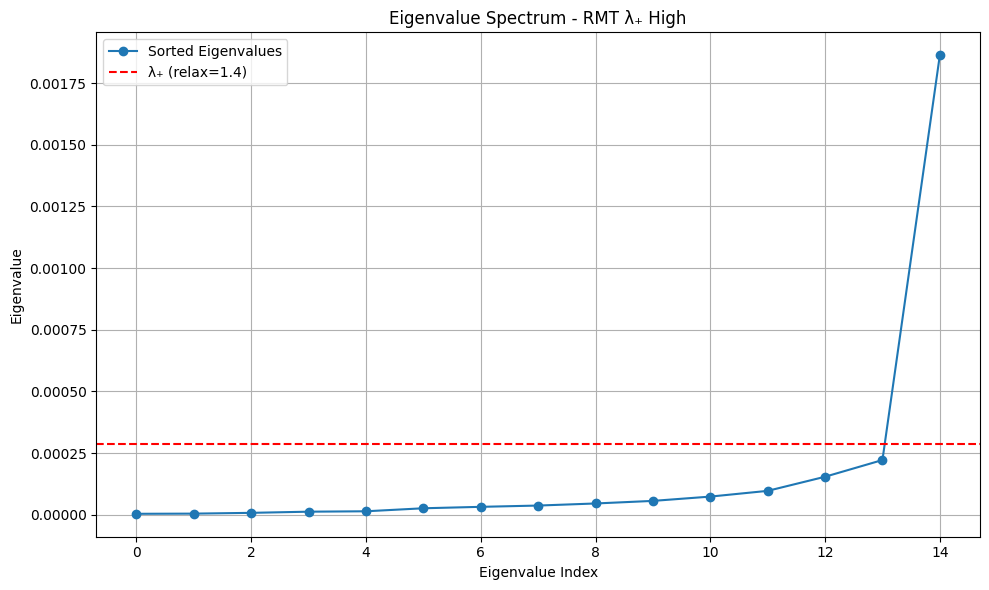

In [63]:
# --- Eigenvalue Spectrum Diagnostic Plot ---
import matplotlib.pyplot as plt
import numpy as np

def plot_eigenvalue_spectrum(returns, relax=1.0, label=""):
    """
    Plot the sorted eigenvalues of the sample covariance matrix,
    along with the Marčenko–Pastur λ₊ threshold.
    """
    T, N = returns.shape
    sample_cov = np.cov(returns, rowvar=False)
    eigenvals = np.sort(np.linalg.eigvalsh(sample_cov))  # sorted ascending

    # Calculate Marčenko–Pastur threshold
    q = T / N
    lambda_plus = (sample_cov.trace() / N) * (1 + 1 / np.sqrt(q))**2 * relax

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvals, marker='o', label='Sorted Eigenvalues')
    plt.axhline(y=lambda_plus, color='red', linestyle='--', label=f'λ₊ (relax={relax})')
    plt.title(f"Eigenvalue Spectrum - {label}")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"eigenvalue_spectrum_{label.replace(' ', '_').replace('λ₊', 'lambda')}.png", dpi=300)
    plt.show()

# Use training set from last regime to ensure consistency
last_train_start, last_train_end, _, _ = regimes[-1]
last_train_prices = prices.loc[last_train_start:last_train_end]
last_train_returns = last_train_prices.pct_change().dropna()

# Plot for RMT λ₊ Base and High
plot_eigenvalue_spectrum(last_train_returns, relax=1.0, label="RMT λ₊ Base")
plot_eigenvalue_spectrum(last_train_returns, relax=1.4, label="RMT λ₊ High")

In [64]:
oos_table.to_csv("Final_Metrics_Table_.csv")

In [65]:
cumulative_returns_df = pd.DataFrame(curves)
cumulative_returns_df.to_csv("cumulative_returns_.csv")
print("Saved: cumulative_returns_.csv")

Saved: cumulative_returns_.csv


In [66]:
prices.to_csv("prices_.csv")
print("Saved: prices_.csv")

Saved: prices_.csv


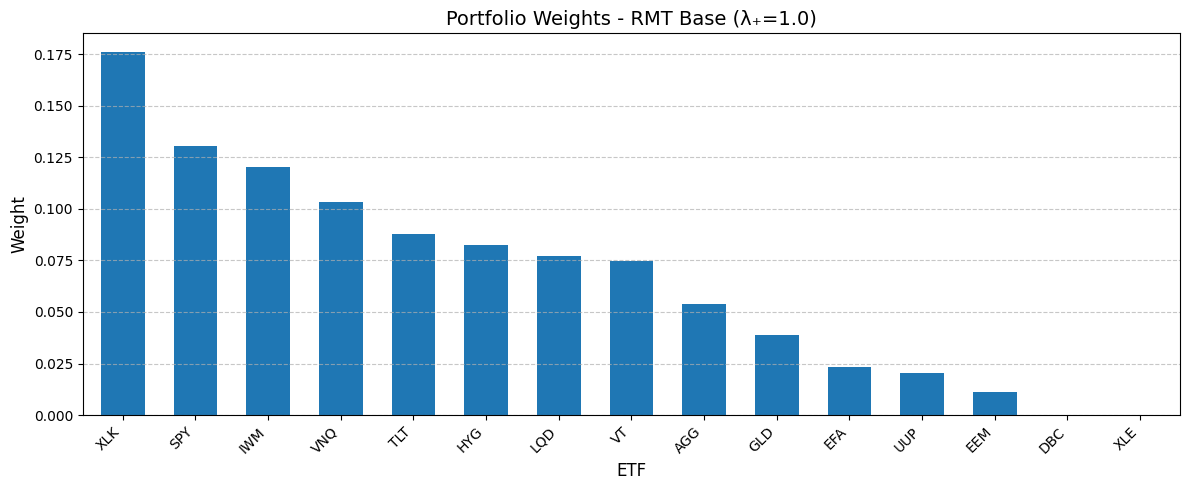

In [67]:
import matplotlib.pyplot as plt

# Create the bar chart
plt.figure(figsize=(12, 5))
weights.plot(kind='bar', width=0.6)
plt.title('Portfolio Weights - RMT Base (λ₊=1.0)', fontsize=14)
plt.ylabel('Weight', fontsize=12)
plt.xlabel('ETF', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('rmt_base_weights.png', dpi=300)

plt.show()